In [147]:
import pandas as pd
import numpy as np
import os
import time
import copy
import pathlib, tempfile

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from graphviz import Digraph
from joblib import Parallel, delayed
from scipy import stats

from survivors import metrics as metr
from survivors import constants as cnt
from survivors import criteria as crit
import survivors.datasets as ds
from numba import njit, jit, int32, float64
from lifelines import KaplanMeierFitter, NelsonAalenFitter

import cProfile
import pstats

%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [148]:
import survivors.datasets as ds
from survivors.ensemble import BoostingCRAID

axis_font = {'fontname':'Times New Roman', 'size':'16'}
sns.set_context(rc={'lines.linewidth':2})

In [149]:
class BoostingVisualize(BoostingCRAID):
    def update_weight(self, index, wei_i):
        super().update_weight(index, wei_i)
        self.visualize_weights(index)
    
    def visualize_weights(self, train_index):
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        oob_index = self.X_train.loc[self.X_train.index.difference(train_index),:]['ind_start']
        ax.set_title(f"Sample probability after {len(self.bettas)} Tree", **axis_font)
        ax.scatter(oob_index, self.weights[oob_index], 10, label = "Out-of-back")
        ax.scatter(train_index, self.weights[train_index], 10, label = "Train")
        ax.set_xlabel("Observation number", **axis_font)
        ax.legend()

[0.168  0.1564 0.1551 0.1547 0.1513 0.1478 0.1438 0.143  0.1414 0.1422]
fitted: 9 models.


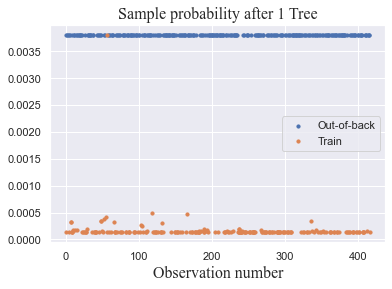

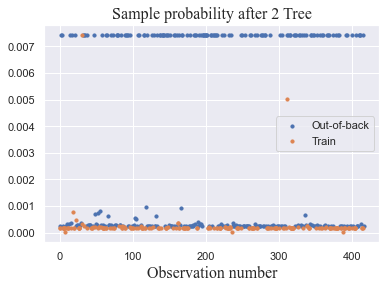

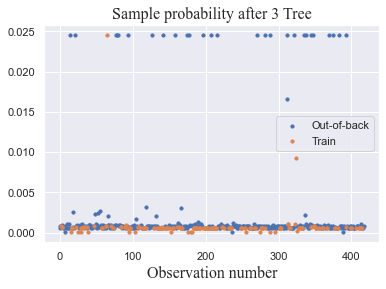

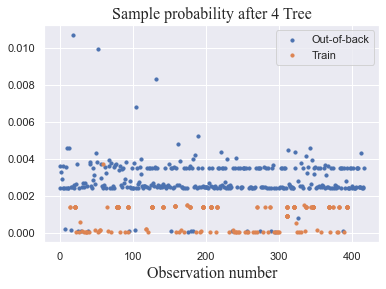

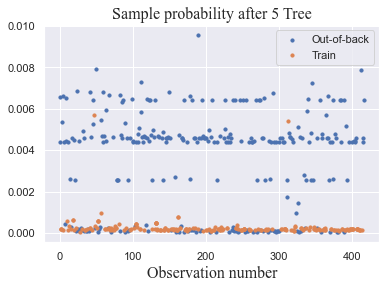

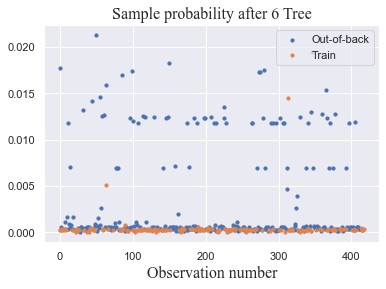

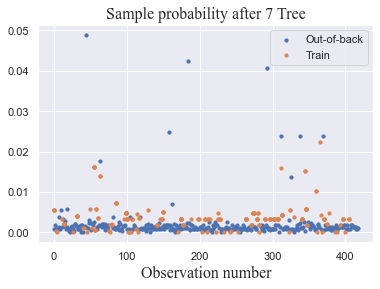

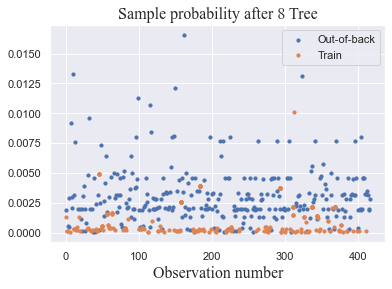

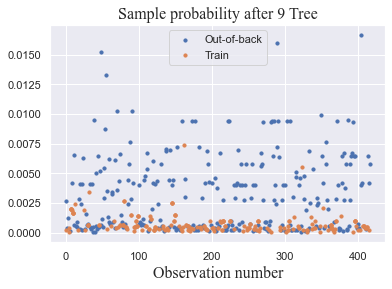

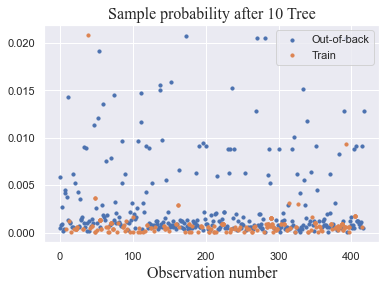

In [150]:
import survivors.datasets as ds
from survivors.ensemble import BoostingCRAID
from sklearn.metrics import roc_auc_score
import cProfile
import pstats

param = {'aggreg_func': 'wei', 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'],
        'criterion': 'weights', 'depth': 15, 'ens_metric_name': 'ibs', 'max_features': 'sqrt',
        'min_samples_leaf': 10, 'mode_wei': 'square', 'n_estimators': 10, 'size_sample': 0.5, 
        "leaf_model": "base_fast", "all_weight": False}

X, y, features, categ, sch_nan = ds.load_pbc_dataset()

bst = BoostingVisualize(**param)
bst.fit(X, y)

[0.168  0.1591 0.1688 0.1648 0.1696 0.1651 0.165  0.1655 0.1646 0.1645]
fitted: 2 models.


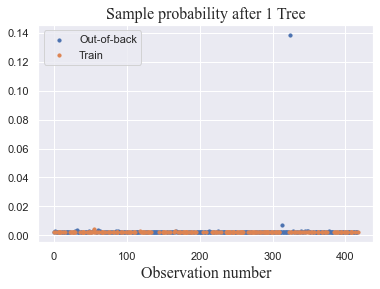

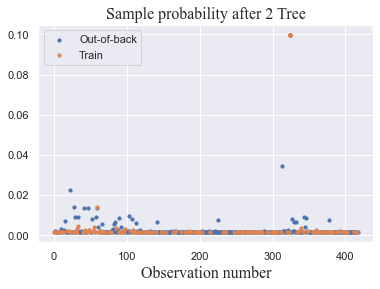

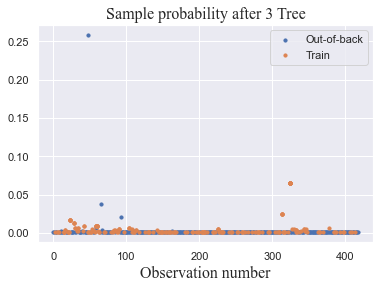

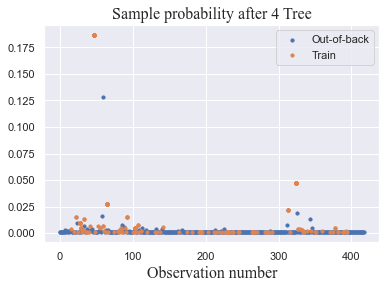

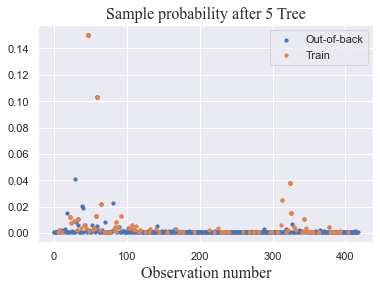

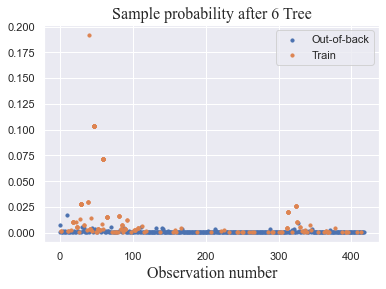

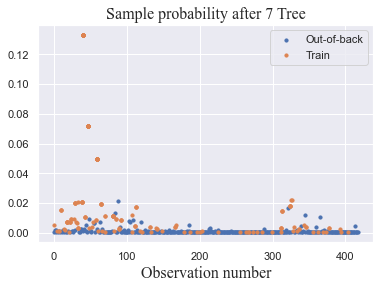

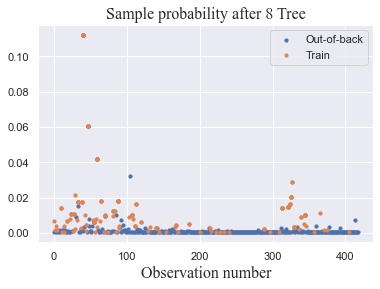

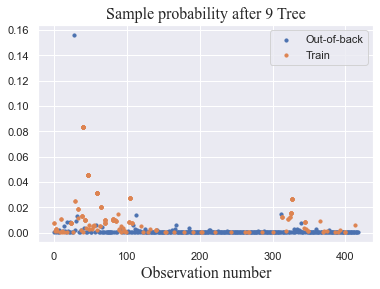

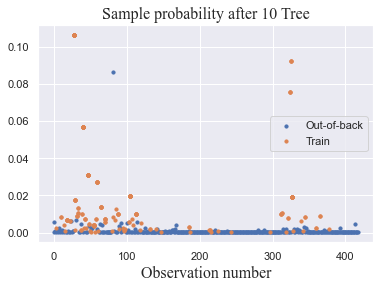

In [23]:
param = {'aggreg_func': 'wei', 'categ': ['trt', 'sex', 'ascites', 'hepato', 'spiders'],
        'criterion': 'weights', 'depth': 15, 'ens_metric_name': 'ibs', 'max_features': 'sqrt',
        'min_samples_leaf': 10, 'mode_wei': 'square', 'n_estimators': 10, 'size_sample': 0.5, 
        "leaf_model": "base_fast", "all_weight": True}

bst = BoostingVisualize(**param)
bst.fit(X, y)

In [55]:
from lifelines import WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter

X_ = X.copy()
X_[cnt.TIME_NAME] = y[cnt.TIME_NAME]
X_[cnt.CENS_NAME] = y[cnt.CENS_NAME]
bins = cnt.get_bins(time=y[cnt.TIME_NAME], cens=y[cnt.CENS_NAME])

X_ = X_.fillna(0).replace(np.nan, 0)
weib = WeibullAFTFitter()
weib.fit(X_, cnt.TIME_NAME, cnt.CENS_NAME)

<lifelines.WeibullAFTFitter: fitted with 418 total observations, 257 right-censored observations>

In [60]:
weib.predict_survival_function(X_, times=bins).to_numpy().T

array([[9.51029692e-01, 9.49294707e-01, 9.47542900e-01, ...,
        1.75666930e-21, 1.72720899e-21, 1.69823945e-21],
       [9.99390320e-01, 9.99368155e-01, 9.99345734e-01, ...,
        5.59628467e-01, 5.59513516e-01, 5.59398575e-01],
       [9.94289702e-01, 9.94082651e-01, 9.93873252e-01, ...,
        4.29307483e-03, 4.28480159e-03, 4.27654334e-03],
       ...,
       [9.99091286e-01, 9.99058254e-01, 9.99024842e-01, ...,
        4.20914594e-01, 4.20785716e-01, 4.20656864e-01],
       [9.99280451e-01, 9.99254293e-01, 9.99227834e-01, ...,
        5.04026083e-01, 5.03903891e-01, 5.03781715e-01],
       [9.98827436e-01, 9.98784819e-01, 9.98741712e-01, ...,
        3.27350162e-01, 3.27220819e-01, 3.27091512e-01]])

In [4]:
X, y, features, categ, sch_nan = ds.load_covid_dataset("C:\\Users\\vasiliev\\Desktop\\PycharmProjects\\dev-survivors\\survivors\\datasets\\data\\COVID")

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\survivors-1.4.4-py3.10.egg\survivors\datasets\covid.py:205: DtypeWarning: Columns (12,33,36,37,46,47,48,49,103,111,112,147,148,247,248,267,268,275,276,283,284,295,296,307,308) have mixed types. Specify dtype option on import or set low_memory=False.
  cyto = pd.read_csv(join(dir_env, "cyto_with_schemes.csv"))


Categ-contin var: has_odyshka_ili_zatrudnennoe_dyhanie
Categ-contin var: has_oschussh_zalozhen_v_grudnoi_kletke
Categ-contin var: has_slabost_ili_lomota
Categ-contin var: Пол
Categ-contin var: PCR_N
Categ-contin var: has_kashel
Categ-contin var: kashel_type
Categorical var: resultat_KT 6


In [18]:
from survivors.ensemble import BoostingCRAID

param = {
    "size_sample": 0.5,
    "n_estimators": 20,
    "ens_metric_name": "ibs",  # "conc",
    "depth": 10,
    "mode_wei": 'exp',
    "criterion": "peto",
    "min_samples_leaf": 100,
    "max_features": 0.3,
    "aggreg_func": 'mean',
    "leaf_model": "base_fast",
    "all_weight": True,  # , False],
    "n_jobs": 5
}


bst = BoostingCRAID(**param)
bst.fit(X[:30000], y[:30000])

[0.1727 0.1622 0.1598 0.1626 0.1632 0.1665 0.1683 0.1688 0.1709 0.1718
 0.1731 0.1749 0.1763 0.1781 0.1794 0.1801 0.181  0.1818 0.1828 0.1836]
fitted: 3 models.


In [56]:
from sklearn.model_selection import StratifiedKFold

def prepare_sample(X, y, train_index, test_index):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    bins = cnt.get_bins(time=y_train[cnt.TIME_NAME], cens=y_train[cnt.CENS_NAME])
    y_train[cnt.TIME_NAME] = np.clip(y_train[cnt.TIME_NAME], bins.min() - 1, bins.max() + 1)
    y_test[cnt.TIME_NAME] = np.clip(y_test[cnt.TIME_NAME], bins.min(), bins.max())
    return X_train, y_train, X_test, y_test, bins

skf = StratifiedKFold(n_splits=5)
train_index = np.array([], dtype=int)
for train_index_, test_index_ in skf.split(X, y[cnt.CENS_NAME]):
    if train_index.shape[0] > 0:
        X_train, y_train, X_test, y_test, bins = prepare_sample(X, y, train_index, test_index_)
        break
    train_index = np.hstack([train_index, test_index_])

(array([13617., 15210.,  2448.,   688.,   231.,    65.,    70.,    64.,
           54.,   137.]),
 array([  0. ,  21.5,  43. ,  64.5,  86. , 107.5, 129. , 150.5, 172. ,
        193.5, 215. ]),
 <BarContainer object of 10 artists>)

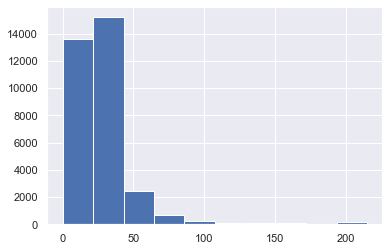

In [48]:
plt.hist(y_test["time"].astype(int))

In [52]:
bst = BoostingCRAID(**param)
bst.fit(X_train, y_train)

[0.1818 0.1677 0.1664 0.1655 0.1675 0.1693 0.1709 0.1728 0.1742 0.176
 0.1779 0.1798 0.1813 0.1822 0.1834 0.1844 0.1857 0.1865 0.1877 0.1885]
fitted: 4 models.


In [53]:
from lifelines.utils import concordance_index

pred_time = bst.predict(X_test, target=cnt.TIME_NAME)
print("CI:", concordance_index(y_test[cnt.TIME_NAME], pred_time))
print("CI_CENS:", concordance_index(y_test[cnt.TIME_NAME], pred_time, y_test[cnt.CENS_NAME]))

CI: 0.4867096722261475
CI_CENS: 0.29392741016451934


In [71]:
y

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [57]:
np.bincount(y_train["cens"]), np.bincount(y_test["cens"])

(array([27433,  5151], dtype=int64), array([27433,  5151], dtype=int64))

In [74]:
np.bincount(y["time"].astype(int))

array([1127, 2449, 2423, 1937, 1980, 2211, 2451, 2703, 2764, 2814, 2665,
       2749, 2664, 2899, 3082, 3027, 3091, 3453, 4166, 5153, 6033, 6544,
       6440, 6613, 6569, 6293, 5983, 5669, 5042, 4454, 3940, 3544, 3090,
       2667, 2470, 2255, 2009, 1724, 1629, 1548, 1428, 1279, 1206, 1087,
        958,  923,  821,  822,  703,  714,  690,  619,  526,  537,  487,
        458,  466,  381,  378,  321,  302,  298,  292,  293,  262,  260,
        243,  236,  196,  213,  189,  187,  175,  161,  148,  162,  142,
        128,  136,  128,   99,  102,   91,   94,  106,   87,   59,   75,
         86,   71,   70,   57,   65,   47,   60,   50,   64,   58,   50,
         53,   41,   40,   38,   38,   27,   30,   23,   29,   19,   14,
         21,   31,   22,   28,   19,    9,   21,   17,   16,   23,   16,
         23,   21,   15,   15,   14,   15,   21,   20,   22,   19,   18,
         17,   18,   14,   25,   12,   12,   18,    8,   13,   10,   18,
         16,   15,   20,   18,   18,   12,   11,   

In [61]:
np.bincount(y_train["time"].astype(int)), np.bincount(y_test["time"].astype(int))

(array([ 213,  483,  499,  392,  385,  456,  464,  523,  570,  577,  539,
         500,  544,  557,  638,  586,  588,  691,  860, 1063, 1228, 1317,
        1240, 1328, 1332, 1296, 1164, 1166, 1014,  906,  745,  699,  593,
         553,  506,  439,  406,  342,  335,  308,  270,  283,  224,  235,
         199,  180,  151,  158,  146,  141,  117,  144,   92,  107,  109,
          90,   90,   75,   79,   61,   72,   58,   59,   57,   54,   49,
          51,   54,   46,   36,   28,   35,   33,   41,   25,   40,   37,
          24,   26,   22,   21,   17,   15,   15,   23,   19,   10,   16,
          16,   16,    9,   17,   11,    8,   14,   11,   13,   11,    7,
          11,    8,    8,   10,    6,    8,    2,    2,    5,    7,    3,
           5,    2,    3,    3,    3,    3,    3,    4,    6,    3,    4,
           6,    6,    1,    4,    5,    2,    1,    5,    5,    5,    3,
           3,    6,    4,    5,    2,    5,    3,    3,    4,    0,    5,
           6,    3,    5,    4,    2, 

In [69]:
y_train

array([(False, 23.), (False, 28.), (False,  2.), ..., ( True, 34.),
       ( True,  0.), ( True,  3.)], dtype=[('cens', '?'), ('time', '<f8')])

In [33]:
pred_time

array([26.82362556, 28.80538623, 27.90500641, ..., 20.87665876,
       26.65939013, 35.66893514])

In [34]:
y[30000:][cnt.TIME_NAME]

array([ 20.,  24.,  21., ...,  10., 156.,  16.])

In [39]:
sum(y[:30000][cnt.CENS_NAME])

4723

In [79]:
a = np.random.uniform(0, 1, 10000)

In [113]:
def get_convergence_sm():
    np.random.seed(42)
    a = np.ones(10000, dtype = np.float64)
    for i in range(10):
        losses = np.random.uniform(0, 1, 10000)
        correct = np.exp(losses/max(losses))
        a *= correct / np.sum(correct)
        plt.hist(a)
    return a
    
def get_convergence_one_exp():
    np.random.seed(42)
    a = np.ones(10000, dtype = float)
    for i in range(10):
        losses = np.random.uniform(0, 1, 10000)
        correct = 1.0 - np.exp(-losses/max(losses))
        a *= correct / np.sum(correct)
        plt.hist(a)
    return a

(array([8625, 1074,  203,   58,   19,   12,    2,    4,    1,    2],
       dtype=int64),
 array([3.03163948e-42, 1.78147576e-40, 3.53263512e-40, 5.28379449e-40,
        7.03495385e-40, 8.78611322e-40, 1.05372726e-39, 1.22884319e-39,
        1.40395913e-39, 1.57907507e-39, 1.75419100e-39]))

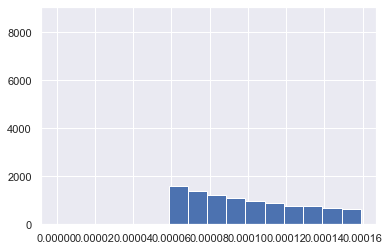

In [114]:
np.histogram(get_convergence_sm())

(array([9696,  200,   61,   21,   10,    4,    4,    2,    0,    2],
       dtype=int64),
 array([2.94531767e-48, 6.62071737e-40, 1.32414347e-39, 1.98621521e-39,
        2.64828694e-39, 3.31035867e-39, 3.97243041e-39, 4.63450214e-39,
        5.29657388e-39, 5.95864561e-39, 6.62071735e-39]))

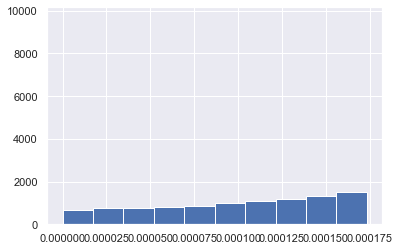

In [115]:
np.histogram(get_convergence_one_exp())

(array([1613., 1310., 1162., 1070., 1012.,  878.,  820.,  747.,  698.,
         690.]),
 array([5.79972633e-05, 6.79627085e-05, 7.79281537e-05, 8.78935989e-05,
        9.78590441e-05, 1.07824489e-04, 1.17789934e-04, 1.27755380e-04,
        1.37720825e-04, 1.47686270e-04, 1.57651715e-04]),
 <BarContainer object of 10 artists>)

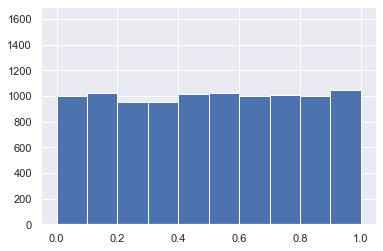

In [90]:
plt.hist(a)
correct_sm = np.exp(a/max(a))
plt.hist(correct/np.sum(correct))

(array([1613., 1310., 1162., 1070., 1012.,  878.,  820.,  747.,  698.,
         690.]),
 array([5.79972633e-05, 6.79627085e-05, 7.79281537e-05, 8.78935989e-05,
        9.78590441e-05, 1.07824489e-04, 1.17789934e-04, 1.27755380e-04,
        1.37720825e-04, 1.47686270e-04, 1.57651715e-04]),
 <BarContainer object of 10 artists>)

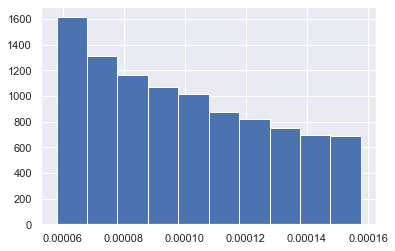

In [91]:
plt.hist(correct_sm/np.sum(correct_sm))

In [135]:
x = ""
eval(x)

SyntaxError: invalid syntax (<string>, line 0)

In [134]:
X.apply(lambda x: f"Tree({x[['mos_light_2', 'mos_middle_1', 'mos_middle_2']].values})", axis=1)

0         Tree([0. 0. 0.])
1         Tree([0. 0. 0.])
2         Tree([0. 0. 0.])
3         Tree([0. 0. 0.])
4         Tree([0. 0. 0.])
                ...       
162913    Tree([0. 0. 0.])
162914    Tree([0. 0. 0.])
162915    Tree([0. 0. 0.])
162916    Tree([0. 0. 0.])
162917    Tree([0. 0. 0.])
Length: 162918, dtype: object

(array([ 655.,  710.,  733.,  790.,  841.,  978., 1081., 1213., 1370.,
        1629.]),
 array([2.04456951e-09, 1.71005277e-05, 3.41990109e-05, 5.12974941e-05,
        6.83959772e-05, 8.54944604e-05, 1.02592944e-04, 1.19691427e-04,
        1.36789910e-04, 1.53888393e-04, 1.70986876e-04]),
 <BarContainer object of 10 artists>)

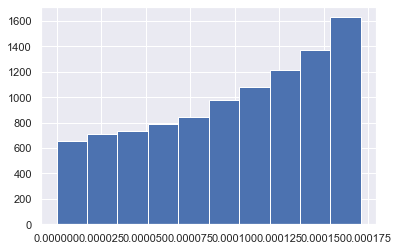

In [92]:
correct_one_sm = 1.0 - np.exp(-a/max(a))
plt.hist(correct_one_sm/np.sum(correct_one_sm))

(array([3980., 1637., 1059.,  771.,  599.,  511.,  405.,  388.,  360.,
         290.]),
 array([1.11686279e-05, 4.52928534e-05, 7.94170789e-05, 1.13541304e-04,
        1.47665530e-04, 1.81789755e-04, 2.15913981e-04, 2.50038206e-04,
        2.84162432e-04, 3.18286657e-04, 3.52410883e-04]),
 <BarContainer object of 10 artists>)

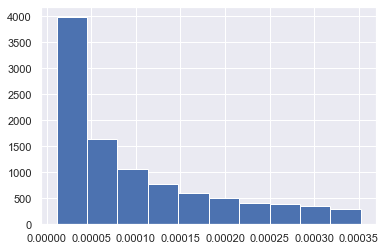

In [122]:
corr = np.exp((a - np.mean(a))/np.std(a))
plt.hist(corr/np.sum(corr))

In [124]:
a 

array([0.83487387, 0.482736  , 0.62094574, ..., 0.35914503, 0.07706707,
       0.96193024])

In [126]:
1/(1+np.exp(-a/max(a)))

array([0.69743765, 0.6184281 , 0.6504762 , ..., 0.58885968, 0.51926304,
       0.72356615])

In [127]:
1.0 - np.exp(-a/max(a))

array([0.56618007, 0.38299715, 0.46266474, ..., 0.30180258, 0.07419376,
       0.61795636])

In [129]:
(a/max(a))**2

array([0.69743499, 0.23317467, 0.38580628, ..., 0.12906299, 0.00594292,
       0.92586817])

In [34]:
((X2 == X2) == (X1 == X2)).all().all() & (y1 == y2).all() & (feat1 == feat2) & (categ1 == categ2)

True

In [4]:
X1.sort_index(axis=1)

,age,gender,max_2019_nCoV_nucleic_acid_detection,max_Activation_of_partial_thromboplastin_time,max_Alkaline_phosphatase,max_Amino_terminal_brain_natriuretic_peptide_precursor_NT_proBNP_,max_Corrected_calcium,max_D_D_dimer,max_Direct_bilirubin,max_ESR,...,min_mean_corpuscular_volume,min_monocytes___,min_monocytes_count,min_neutrophils___,min_neutrophils_count,min_platelet_large_cell_ratio_,min_procalcitonin,min_serum_sodium,min_thrombocytocrit,min_total_protein
0,73,1,-1.0,38.9,71.0,60.0,2.53,2.20,5.5,41.0,...,91.1,4.9,0.38,60.9,2.33,29.3,0.09,137.7,0.12,62.2
1,61,1,-1.0,42.3,45.0,173.0,2.49,0.96,8.0,40.0,...,90.8,3.2,0.24,67.1,5.83,19.8,0.09,137.0,0.27,70.4
2,70,2,-1.0,34.8,69.0,NaN,2.32,0.98,5.1,66.0,...,93.6,5.9,0.22,60.1,2.79,21.4,0.06,135.7,0.20,62.2
3,74,1,-1.0,NaN,79.0,152.0,2.42,1.26,8.5,72.0,...,113.3,3.8,0.23,65.0,3.42,16.3,0.38,137.9,0.10,65.3
4,29,2,-1.0,NaN,84.0,5.0,2.43,0.42,2.3,15.0,...,86.8,6.8,0.30,54.9,2.43,22.7,0.02,140.2,0.22,70.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,63,1,NaN,43.8,65.0,NaN,2.34,2.57,4.2,19.0,...,87.9,5.5,0.28,79.5,4.07,33.0,1.51,135.8,0.16,64.0
371,79,1,NaN,59.2,180.0,17992.0,2.52,11.11,52.5,93.0,...,85.7,0.9,0.26,90.3,8.79,40.8,1.14,147.0,0.07,46.3
372,61,2,NaN,36.7,141.0,NaN,2.29,NaN,4.9,NaN,...,80.9,4.5,0.55,89.0,10.80,46.1,0.56,141.6,0.18,60.8
373,33,1,NaN,44.9,144.0,2102.0,2.15,21.00,18.4,19.0,...,84.8,1.7,0.23,94.5,13.20,30.1,NaN,146.2,0.13,55.5


In [2]:
X1, y1, feat1, categ1, nans1 = ds.load_wuhan_dataset()
X1

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(


,max_HCV_antibody_quantification,max_Serum_potassium,min_RBC_distribution_width_SD,max_ESR,max_D_D_dimer,max_monocytes___,min_HCO3_,mean_indirect_bilirubin,mean_thrombocytocrit,max_Quantification_of_Treponema_pallidum_antibodies,...,max____lymphocyte,mean_creatinine,min_glutamic_pyruvic_transaminase,mean_Total_cholesterol,max_Total_bilirubin,min_Interleukin_6,min_HBsAg,mean_Quantification_of_Treponema_pallidum_antibodies,min_Hypersensitive_cardiac_troponinI,min_calcium
0,0.06,5.15,39.0,41.0,2.20,10.7,21.2,5.920000,0.170000,0.05,...,28.7,99.000000,16.0,4.164000,16.6,NaN,0.03,0.05,19.9,2.02
1,0.10,4.84,39.8,40.0,0.96,8.3,21.7,7.325000,0.317500,0.06,...,24.3,79.250000,22.0,4.655000,16.5,8.92,0.00,0.06,1.9,1.98
2,0.06,3.90,42.7,66.0,0.98,6.4,22.3,5.000000,0.240000,0.07,...,33.1,63.666667,19.0,3.746667,12.6,47.82,0.01,0.07,NaN,2.07
3,0.06,3.92,49.4,72.0,1.26,10.9,22.8,5.150000,0.207500,0.04,...,22.5,84.500000,20.0,2.845000,15.5,NaN,0.00,0.04,4.8,2.08
4,0.05,4.68,38.6,15.0,0.42,7.4,25.6,2.750000,0.316667,0.05,...,37.9,56.000000,12.0,2.960000,6.2,1.50,0.01,0.05,5.6,2.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,NaN,3.89,38.8,19.0,2.57,5.5,24.8,2.900000,0.160000,NaN,...,15.0,81.000000,31.0,3.280000,7.1,248.90,NaN,NaN,1741.5,2.01
371,0.03,7.08,46.1,93.0,11.11,7.0,13.0,4.088889,0.172000,0.18,...,2.2,297.363636,20.0,2.818889,58.1,284.30,0.00,0.18,6.8,1.30
372,NaN,4.22,38.7,NaN,NaN,4.5,25.4,4.100000,0.180000,NaN,...,6.3,47.000000,9.0,2.570000,9.0,NaN,NaN,NaN,124.8,1.97
373,0.05,4.53,NaN,19.0,21.00,2.9,18.8,7.200000,0.130000,0.06,...,2.3,109.333333,75.0,2.730000,26.0,23.15,0.01,0.06,372.4,1.85


In [18]:
X2, y2, feat2, categ2, nans2 = ds.load_wuhan_dataset()
X2

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axi

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of emp

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(
C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\pandas\core\apply.py:1137: RuntimeWarning: All-NaN axis encountered
  mapped = lib.map_infer(


,min_Hypersensitive_cardiac_troponinI,max_mean_corpuscular_hemoglobin_,mean_Lactate_dehydrogenase,max_antithrombin,max_Total_cholesterol,min_hemoglobin,max_lymphocyte_count,min_Interleukin_8,mean_Eosinophil_count,max_albumin,...,max_2019_nCoV_nucleic_acid_detection,max_mean_corpuscular_hemoglobin_concentration,mean_HBsAg,min_Interleukin_10,mean_fibrinogen,max_Prothrombin_activity,max_HCO3_,mean_Interleukin_1_,min_antithrombin,max_fibrinogen
0,19.9,32.6,232.000000,NaN,4.84,129.0,2.60,NaN,0.064000,37.6,...,-1.0,353.0,0.03,NaN,3.220000,115.0,31.0,NaN,NaN,3.28
1,1.9,32.3,450.250000,NaN,5.06,135.0,2.11,12.3,0.005000,37.2,...,-1.0,352.0,0.00,7.5,4.675000,117.0,27.7,5.0,NaN,5.58
2,NaN,33.3,274.333333,84.0,4.47,109.0,2.10,21.9,0.006667,38.4,...,-1.0,353.0,0.01,8.1,5.330000,94.0,25.3,5.0,84.0,5.33
3,4.8,44.2,293.500000,NaN,3.13,84.0,1.55,NaN,0.132500,34.1,...,-1.0,372.0,0.00,NaN,NaN,68.0,27.4,NaN,NaN,NaN
4,5.6,30.0,187.000000,NaN,3.43,120.0,1.88,16.6,0.150000,40.2,...,-1.0,344.0,0.01,5.0,NaN,83.0,28.1,16.4,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,1741.5,30.4,573.000000,NaN,3.28,143.0,0.77,21.6,0.000000,30.7,...,NaN,346.0,NaN,39.6,5.480000,86.0,24.8,5.0,NaN,5.48
371,6.8,30.4,383.666667,81.0,3.33,102.0,0.43,92.3,0.044000,25.1,...,NaN,351.0,0.00,10.3,8.351667,89.0,19.9,5.0,68.0,10.78
372,124.8,27.6,702.000000,NaN,2.57,100.0,0.76,NaN,0.010000,23.9,...,NaN,341.0,NaN,NaN,5.270000,77.0,25.4,NaN,NaN,5.27
373,372.4,30.7,1706.333333,76.0,2.82,117.0,0.33,41.0,0.000000,28.0,...,NaN,349.0,0.01,10.9,1.745000,66.0,22.0,88.5,76.0,2.99


In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split

def prepare_sample(X, y, train_index, test_index):
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    bins = cnt.get_bins(time=y_train[cnt.TIME_NAME], cens=y_train[cnt.CENS_NAME])
    y_train[cnt.TIME_NAME] = np.clip(y_train[cnt.TIME_NAME], bins.min() - 1, bins.max() + 1)
    y_test[cnt.TIME_NAME] = np.clip(y_test[cnt.TIME_NAME], bins.min(), bins.max())
    return X_train, y_train, X_test, y_test, bins

def generate_sample(X, y, folds):
    skf = StratifiedKFold(n_splits=folds)
#     X_TR, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME], test_size=0.33, random_state=42)
#     X, y, X_HO, y_HO, bins_HO = prepare_sample(X, y, X_TR.index, X_HO.index)
#     X = X.reset_index()
    for train_index, test_index in skf.split(X, y[cnt.CENS_NAME]):
        X_train, y_train, X_test, y_test, bins = prepare_sample(X, y, train_index, test_index)
        yield X_train, y_train, X_test, y_test, bins
#     yield X, y, X_HO, y_HO, bins_HO
    pass

X, y, feat, categ, nans = ds.load_gbsg_dataset()
for X_tr, y_tr, X_tst, y_tst, bins in generate_sample(X, y, 5):
    print(X_tr)
    print(X_tst)

     htreat  age  menostat  tumsize  tumgrad  posnodal  prm  esm
120       0   50         2       52        2         1    0    0
121       0   45         1       29        2         1    0    0
122       0   51         1       20        2         1    0    0
124       1   56         2       40        2         3    0    3
125       0   60         2       15        2         2   84   93
..      ...  ...       ...      ...      ...       ...  ...  ...
681       0   49         1       30        3         3    1   84
682       1   53         2       25        3        17    0    0
683       0   51         1       25        3         5   43    0
684       0   52         2       23        2         3   15   34
685       0   55         2       23        2         9  116   15

[548 rows x 8 columns]
     htreat  age  menostat  tumsize  tumgrad  posnodal  prm  esm
0         0   70         2       21        2         3   48   66
1         1   56         2       12        2         7   61   77
2

In [ ]:
# Int64Index([ 91,  93,  94,  95,  96,  97,  98,  99, 100, 101,
#             ...
#             449, 450, 451, 452, 453, 454, 455, 456, 457, 458],
#            dtype='int64', length=367)
# Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
#             17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
#             34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
#             51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
#             68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
#             85, 86, 87, 88, 89, 90, 92],
#            dtype='int64')
# Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
#             ...
#             449, 450, 451, 452, 453, 454, 455, 456, 457, 458],
#            dtype='int64', length=367)
# Int64Index([ 91,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
#             105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
#             118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
#             131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
#             144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
#             157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
#             170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 183,
#             184],
#            dtype='int64')
# Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
#             ...
#             449, 450, 451, 452, 453, 454, 455, 456, 457, 458],
#            dtype='int64', length=367)
# Int64Index([182, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196,
#             197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209,
#             210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222,
#             223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235,
#             236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248,
#             249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261,
#             262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274,
#             276],
#            dtype='int64')
# Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
#             ...
#             449, 450, 451, 452, 453, 454, 455, 456, 457, 458],
#            dtype='int64', length=367)
# Int64Index([275, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288,
#             289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
#             302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314,
#             315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327,
#             328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340,
#             341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353,
#             354, 355, 356, 357, 358, 361, 362, 363, 364, 365, 366, 368, 369,
#             371],
#            dtype='int64')
# Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
#             ...
#             358, 361, 362, 363, 364, 365, 366, 368, 369, 371],
#            dtype='int64', length=368)
# Int64Index([359, 360, 367, 370, 372, 373, 374, 375, 376, 377, 378, 379, 380,
#             381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393,
#             394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406,
#             407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419,
#             420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432,
#             433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445,
#             446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458],
#            dtype='int64')
# RangeIndex(start=0, stop=459, step=1)
# Int64Index([449, 545, 200, 217,   3, 597, 240, 479, 547, 653,
#             ...
#              15, 467, 408, 191, 665, 583,   4,  31, 136, 215],
#            dtype='int64', length=227)

In [3]:
from sklearn.model_selection import train_test_split

X, y, feat, categ, nans = ds.load_gbsg_dataset()
# for i in range(10):
#     X_tr, X_HO = train_test_split(X, stratify=y[cnt.CENS_NAME], test_size=0.33, random_state=42)
#     print(X_tr.index)
#     print(X_HO.index)
#     print("="*20)
    
# Int64Index([310, 288, 204, 274, 145, 243,  73, 212, 366, 338,
#             ...
#             318, 315, 114,  85, 371, 230,  18, 119,   6, 141],
#            dtype='int64', length=251) Int64Index([282, 270, 364, 312, 199, 224, 211, 248, 321, 323,
#             ...
#             200, 181,  88,  50,  74,  72, 269,  14, 253, 106],
#            dtype='int64', length=124)

NameError: name 'ds' is not defined

==================== COVID ====================


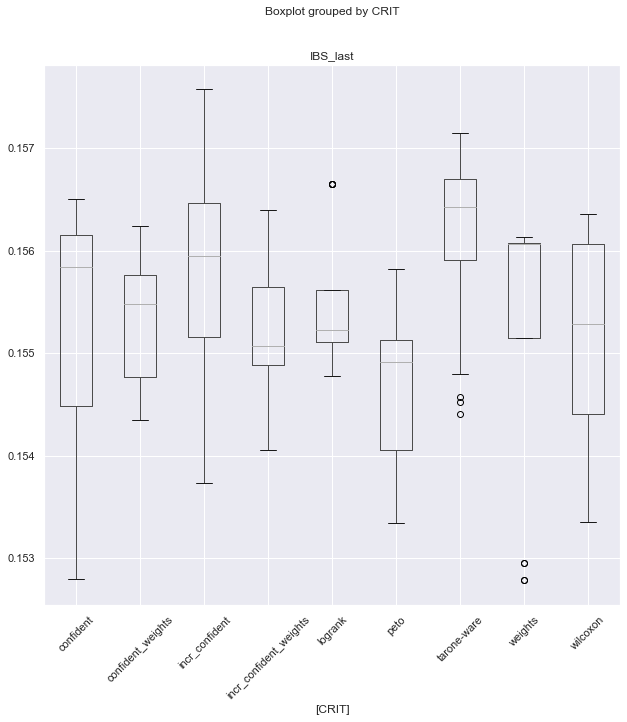

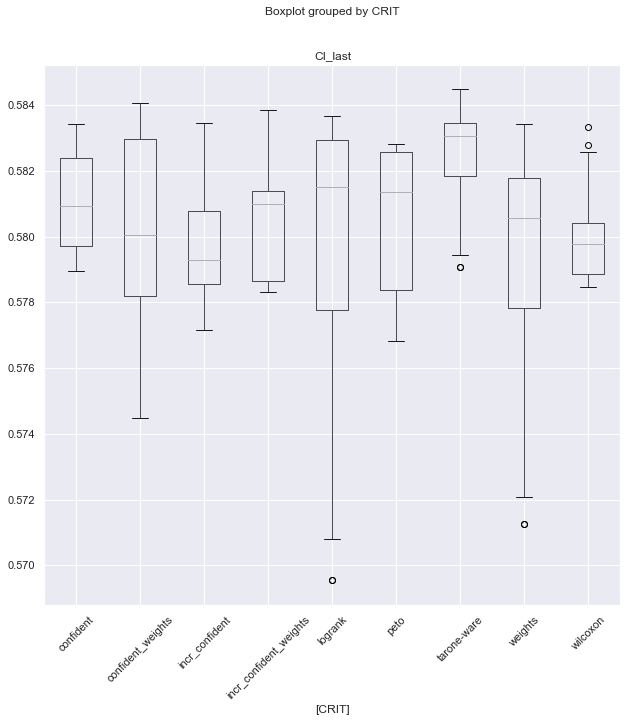

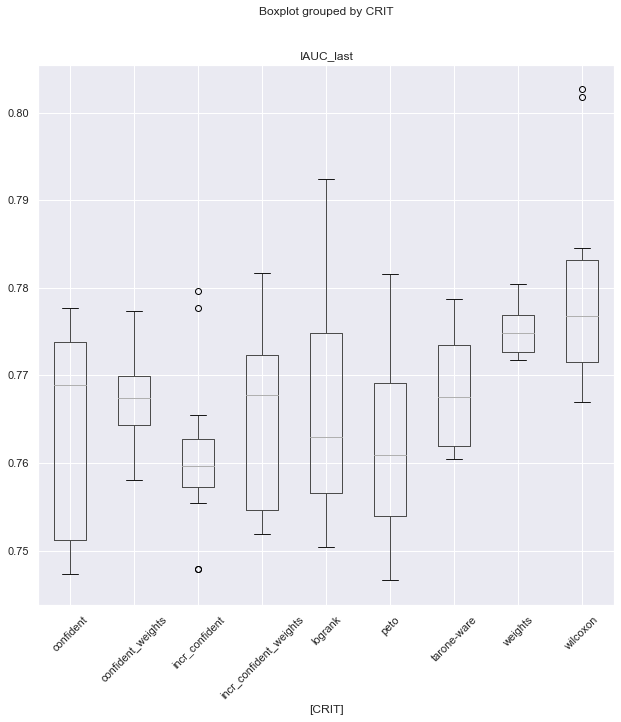

==================== ONK ====================


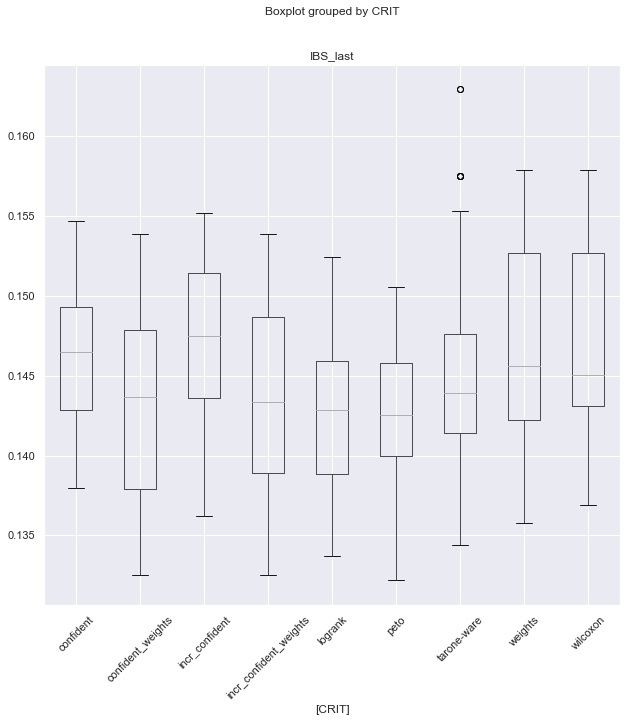

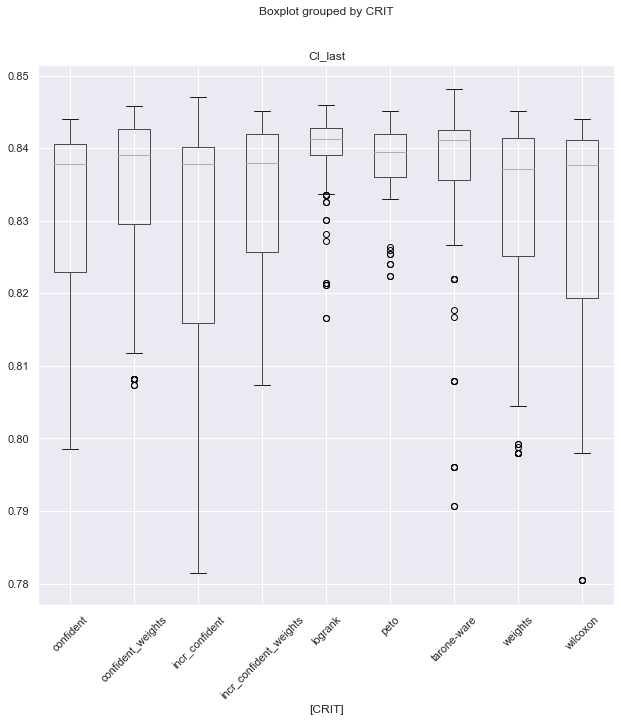

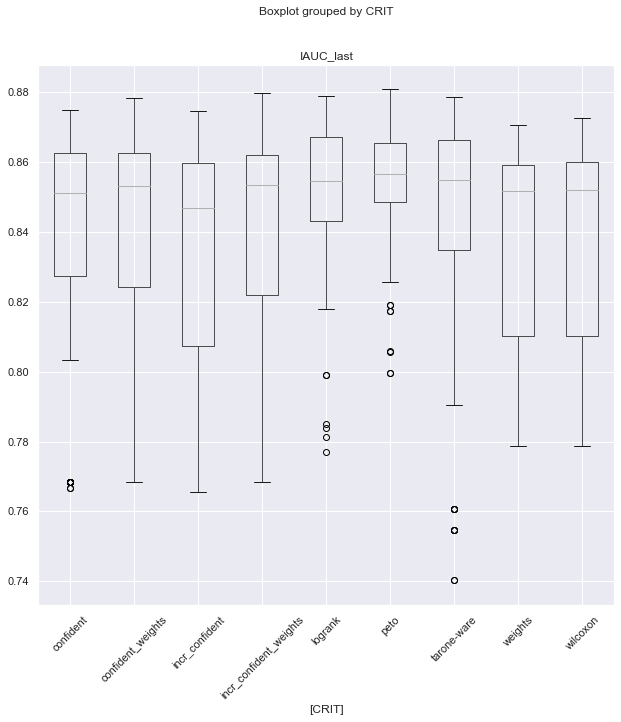

==================== GBSG ====================


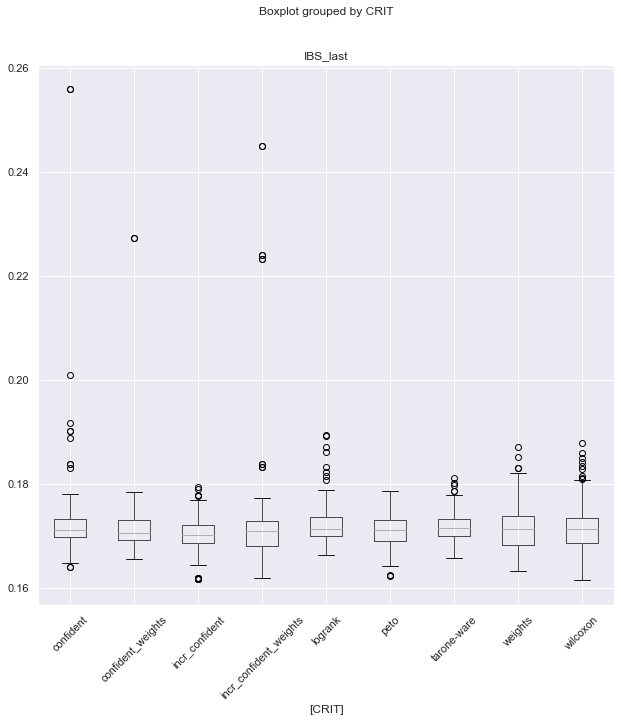

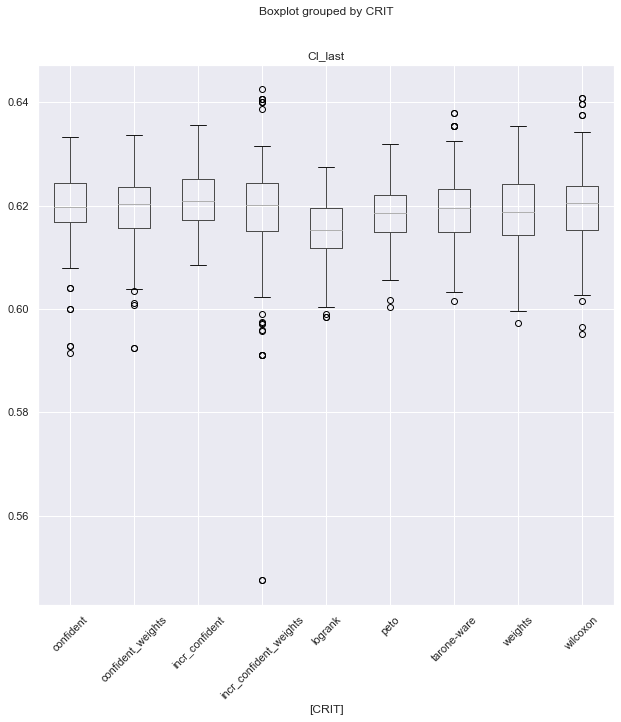

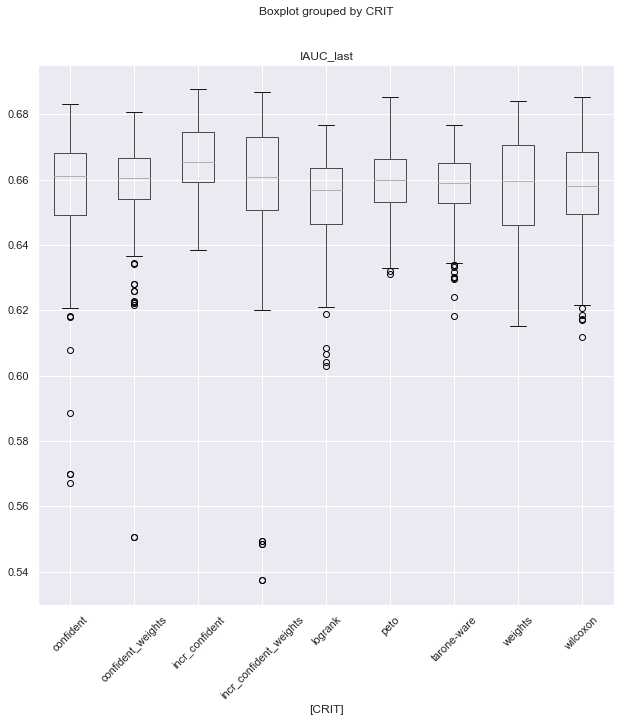

==================== PBC ====================


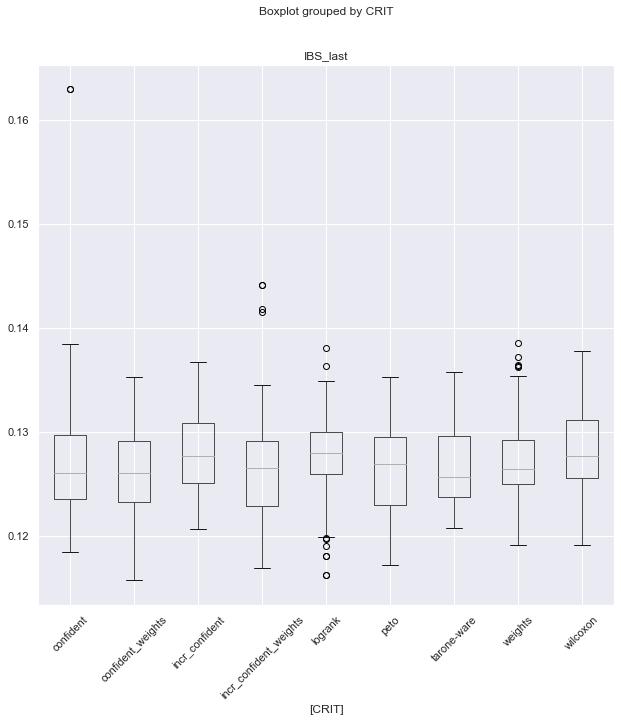

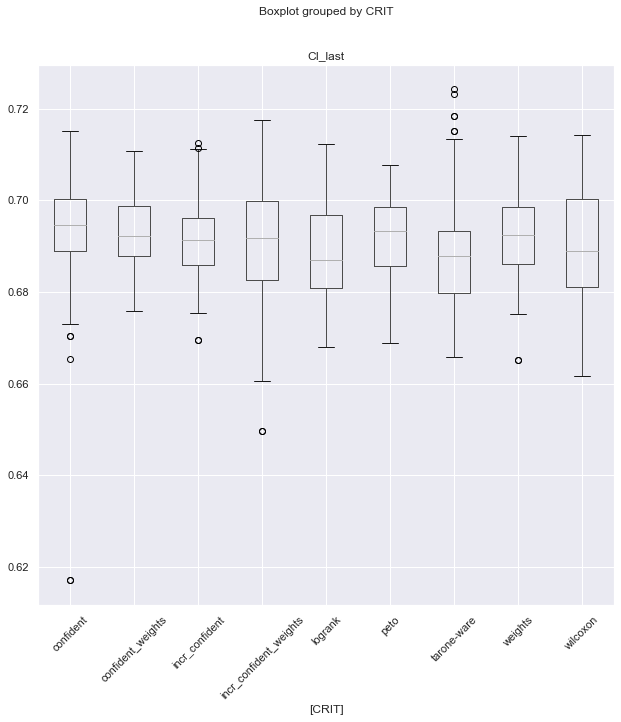

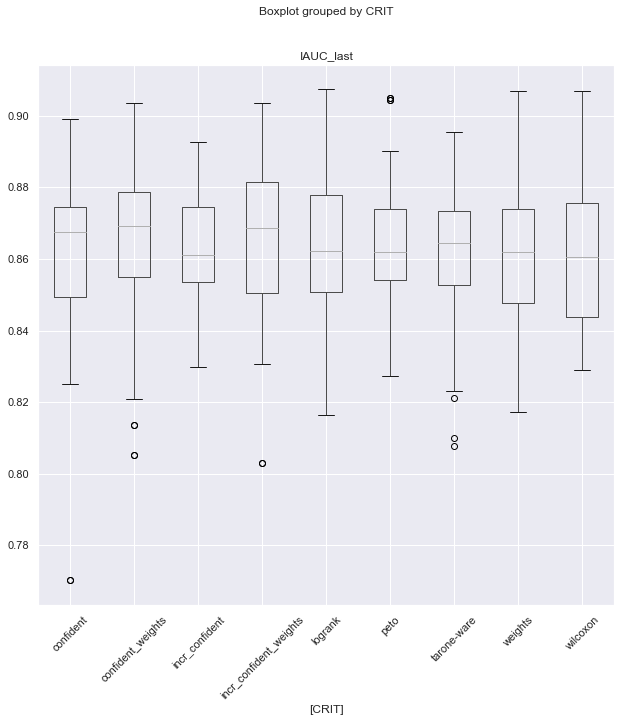

==================== WUHAN ====================


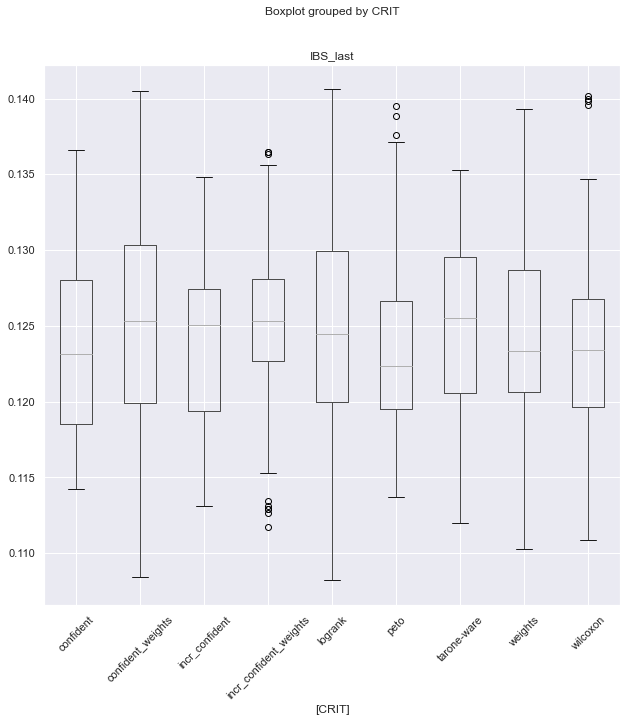

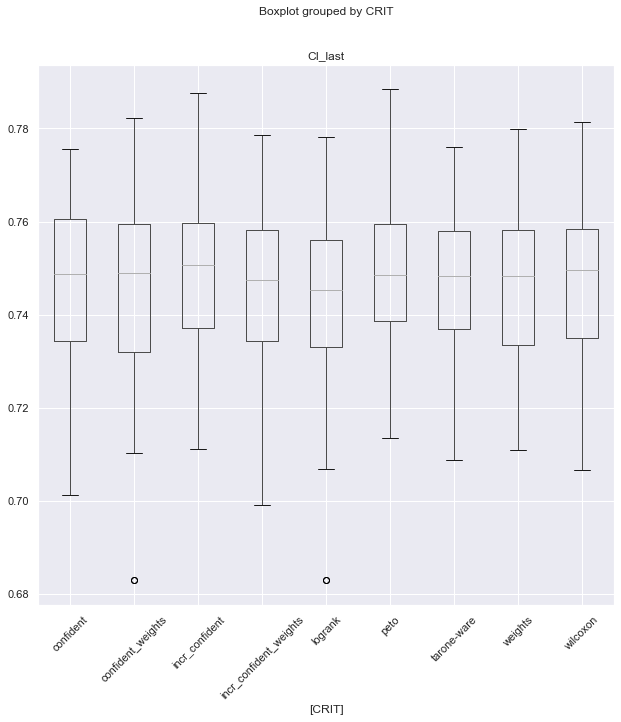

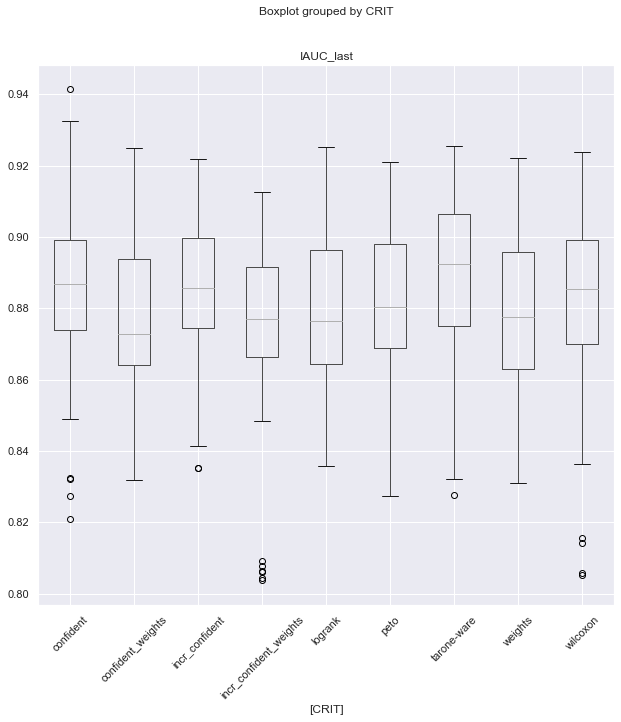

In [8]:
glob_dir = "C:\\Users\\vasiliev\\Desktop\\PycharmProjects\\dev-survivors\\experiment_results\\"
# datasets = ["COVID\\TIME-CV\\crit_mode_stratified\\COVID_TIME-CV_full.xlsx",
#             "ONK\\TIME-CV\\crit_mode_stratified\\ONK_TIME-CV_full.xlsx",
#             "GBSG\\TIME-CV\\crit_mode_stratified\\GBSG_FULL_TABLE.xlsx",
#             "PBC\\TIME-CV\\crit_mode_stratified\\PBC_TIME-CV_full.xlsx",
#             "WUHAN\\TIME-CV\\crit_mode_stratified\\WUHAN_TIME-CV_full.xlsx"]

datasets = [
    "COVID\\HOLD_OUT\\join_strat_hold\\COVID_FULL_TABLE.xlsx",
    "ONK\\HOLD_OUT\\join_strat_hold\\ONK_FULL_TABLE.xlsx",
    "GBSG\\HOLD_OUT\\join_strat_hold\\GBSG_FULL_TABLE.xlsx",
    "PBC\\HOLD_OUT\\join_strat_hold\\PBC_FULL_TABLE.xlsx",
    "WUHAN\\HOLD_OUT\\join_strat_hold\\WUHAN_FULL_TABLE.xlsx"
]

add_datasets = [
    "COVID\\HOLD_OUT\\strat_new_conf\\COVID_FULL_TABLE.xlsx",
    "ONK\\HOLD_OUT\\strat_new_conf\\ONK_FULL_TABLE.xlsx",
    "GBSG\\HOLD_OUT\\strat_new_conf\\GBSG_FULL_TABLE.xlsx",
    "PBC\\HOLD_OUT\\strat_new_conf\\PBC_FULL_TABLE.xlsx",
    "WUHAN\\HOLD_OUT\\strat_new_conf\\WUHAN_FULL_TABLE.xlsx"
]

for dat, add in zip(datasets, add_datasets):
    print("="*20, dat[:dat.find("\\")], "="*20)
    res_table = pd.read_excel(glob_dir + dat)
    add_table = pd.read_excel(glob_dir + add)
    add_table["CRIT"] = "incr_" + add_table["CRIT"]
    res_table = pd.concat([res_table, add_table])
    for m in ["IBS_last", "CI_last", "IAUC_last"]:
        res_table.loc[:, [m, "CRIT"]].boxplot(by = "CRIT", figsize=(10, 10), rot=45)
    plt.show()

In [215]:
res_table.groupby("CRIT").aggregate(np.min)

,METHOD,PARAMS,TIME,CI,CI_CENS,IBS,IAUC,CI_pred_mean,CI_CENS_pred_mean,IBS_pred_mean,IAUC_pred_mean,CI_last,CI_CENS_last,IBS_last,IAUC_last,CI_mean,CI_CENS_mean,IBS_mean,IAUC_mean
CRIT,,,,,,,,,,,,,,,,,,,
confident,BoostingCRAID,"{'aggreg_func': 'mean', 'all_weight': False, '...",58.856314,[0.65491803 0.72075149 0.74006762 0.74181034 0...,[0.86795048 0.8985115 0.82298137 0.84938942 0...,[0.15276298 0.11611413 0.17801595 0.1108034 0...,[0.54333677 0.97070843 0.62673561 0.93560498 0...,0.704670,0.838398,0.120175,0.697096,0.729609,0.866039,0.110668,0.855156,0.713579,0.847187,0.120064,0.727202
confident_weights,BoostingCRAID,"{'aggreg_func': 'mean', 'all_weight': False, '...",57.295434,[0.63114754 0.78309137 0.70498732 0.79051724 0...,[0.84044017 0.83355886 0.85869565 0.83717775 0...,[0.14692478 0.13699579 0.19346938 0.09870911 0...,[0.57398378 0.98073649 0.61720232 0.93579516 0...,0.691573,0.834354,0.120713,0.675665,0.727073,0.856631,0.112660,0.819965,0.699864,0.841800,0.119938,0.708659
incr_confident,BoostingCRAID,"{'aggreg_func': 'mean', 'all_weight': False, '...",59.347474,[0.62704918 0.77284372 0.66483516 0.80948276 0...,[0.85006878 0.84641407 0.74068323 0.88331072 0...,[0.1548945 0.11258081 0.19777517 0.07740665 0...,[0.51235716 0.96567595 0.6946132 0.94429341 0...,0.703241,0.831660,0.117049,0.675321,0.688074,0.835797,0.113283,0.822420,0.706288,0.842467,0.116482,0.714065
incr_confident_weights,BoostingCRAID,"{'aggreg_func': 'mean', 'all_weight': False, '...",56.818175,[0.60942623 0.72672929 0.63905325 0.76982759 0...,[0.85281981 0.90798376 0.74068323 0.89823609 0...,[0.15308907 0.11691683 0.23401005 0.09169439 0...,[0.51097481 0.98065853 0.71586172 0.96092071 0...,0.700875,0.847317,0.119973,0.699108,0.721247,0.849350,0.113211,0.824376,0.709695,0.848477,0.119738,0.728291
logrank,BoostingCRAID,"{'aggreg_func': 'mean', 'all_weight': False, '...",47.844399,[0.6192623 0.73185312 0.68385461 0.78793103 0...,[0.83700138 0.8985115 0.8121118 0.86702849 0...,[0.15342527 0.12779982 0.18986928 0.10886264 0...,[0.53923503 0.9774702 0.66916529 0.95395859 0...,0.712360,0.859070,0.120719,0.708332,0.719328,0.846886,0.110685,0.842098,0.717976,0.862052,0.122179,0.737864
peto,BoostingCRAID,"{'aggreg_func': 'mean', 'all_weight': False, '...",49.128315,[0.62540984 0.71221178 0.68681319 0.7637931 0...,[0.86657497 0.90663058 0.84937888 0.8697422 0...,[0.14998253 0.13054748 0.19112979 0.15672553 0...,[0.52595378 0.96249323 0.69664276 0.93866377 0...,0.694218,0.864890,0.120489,0.703743,0.716244,0.851142,0.112262,0.828068,0.704286,0.870560,0.120831,0.733496
tarone-ware,BoostingCRAID,"{'aggreg_func': 'mean', 'all_weight': False, '...",48.696095,[0.6147541 0.75149445 0.71048183 0.77327586 0...,[0.85557084 0.89986468 0.83695652 0.88195387 0...,[0.14600812 0.11923368 0.18105326 0.15672553 0...,[0.54614413 0.9775587 0.58291299 0.92402149 0...,0.697716,0.856108,0.119553,0.693016,0.729404,0.855511,0.108970,0.844719,0.705430,0.860284,0.120310,0.722603
weights,BoostingCRAID,"{'aggreg_func': 'mean', 'all_weight': False, '...",49.731621,[0.61188525 0.71989752 0.67328825 0.77931034 0...,[0.85694635 0.90933694 0.86645963 0.88738128 0...,[0.14553599 0.13269614 0.18579386 0.1240213 0...,[0.53825699 0.96419394 0.61905752 0.93822767 0...,0.702380,0.847554,0.118586,0.698215,0.722961,0.846214,0.113203,0.842692,0.710985,0.852987,0.117688,0.729266
wilcoxon,BoostingCRAID,"{'aggreg_func': 'mean', 'all_weight': False, '...",49.627438,[0.64877049 0.74466268 0.68596788 0.80862069 0...,[0.86451169 0.8985115 0.81754658 0.88738128 0...,[0.13823737 0.13499573 0.23304308 0.10105663 0...,[0.53839213 0.96419394 0.61905752 0.93162331 0...,0.708966,0.847410,0.118506,0.696922,0.728307,0.863127,0.113203,0.851954,0.716702,0.855331,0.117622,0.730215


In [99]:
df_strat_criterion = [
    "COVID\\HOLD_OUT\\join_strat_hold\\strat_criterion_COVID_HOLD-OUT_best.xlsx",
    "ONK\\HOLD_OUT\\join_strat_hold\\strat_criterion_ONK_HOLD-OUT_best.xlsx",
    "GBSG\\HOLD_OUT\\join_strat_hold\\strat_criterion_GBSG_HOLD-OUT_best.xlsx",
    "PBC\\HOLD_OUT\\join_strat_hold\\strat_criterion_PBC_HOLD-OUT_best.xlsx",
    "WUHAN\\HOLD_OUT\\join_strat_hold\\strat_criterion_WUHAN_HOLD-OUT_best.xlsx"
]

df_strat_wei = [
    "COVID\\HOLD_OUT\\join_strat_hold\\strat_mode_wei_COVID_HOLD-OUT_best.xlsx",
    "ONK\\HOLD_OUT\\join_strat_hold\\strat_mode_wei_ONK_HOLD-OUT_best.xlsx",
    "GBSG\\HOLD_OUT\\join_strat_hold\\strat_mode_wei_GBSG_HOLD-OUT_best.xlsx",
    "PBC\\HOLD_OUT\\join_strat_hold\\strat_mode_wei_PBC_HOLD-OUT_best.xlsx",
    "WUHAN\\HOLD_OUT\\join_strat_hold\\strat_mode_wei_WUHAN_HOLD-OUT_best.xlsx"
]

metr_table = ["CI_HO", "IBS_HO", "IAUC_HO"]
final_table = pd.DataFrame([])

for dat in df_strat_wei:
    dat_name = dat[:dat.find("\\")]
    print("="*10, dat_name, "="*10)
    res_table = pd.read_excel(glob_dir + dat).round(5)
    res_table = res_table.set_index('Stratify(mode_wei)')
    invert_table = res_table.loc[:, metr_table].T
    criteria = invert_table.columns
    final_table[dat_name] = pd.concat([
        invert_table.iloc[[0, 2], :].apply(lambda x: list(criteria[np.argsort(x)[-3:][::-1]]), axis = 1), 
        invert_table.iloc[[1], :].apply(lambda x: list(criteria[np.argsort(x)[:3]]), axis = 1)])
#         if m == "IBS_HO":
#             ind = res_table[m].sort_values()[:3].index
#         else:
#             ind = res_table[m].sort_values()[-3:].index[::-1]
#         print(m)
#         print(res_table.loc[ind, ["CRIT", m]].values)

========== COVID ==========
========== ONK ==========
========== GBSG ==========
========== PBC ==========
========== WUHAN ==========


In [100]:
final_table.T

,CI_HO,IAUC_HO,IBS_HO
COVID,"[sigmoid, exp, square]","[exp, softmax, square]","[softmax, sigmoid, exp]"
ONK,"[sigmoid, square, exp]","[exp, sigmoid, square]","[exp, square, sigmoid]"
GBSG,"[softmax, exp, sigmoid]","[softmax, exp, sigmoid]","[exp, softmax, sigmoid]"
PBC,"[softmax, square, exp]","[softmax, sigmoid, exp]","[softmax, exp, sigmoid]"
WUHAN,"[sigmoid, square, linear]","[sigmoid, softmax, square]","[sigmoid, square, softmax]"


In [101]:
from collections import Counter
 
def most_frequent(lst):
    counted_pairs = Counter(lst).most_common()
    return [counted_pairs[0][1]] + [el[0] for el in counted_pairs if el[1] == counted_pairs[0][1]]

final_table.sum(axis = 0).apply(most_frequent)

COVID                      [3, exp]
ONK       [3, sigmoid, square, exp]
GBSG     [3, softmax, exp, sigmoid]
PBC               [3, softmax, exp]
WUHAN          [3, sigmoid, square]
dtype: object

In [102]:
final_table.sum(axis = 1).apply(most_frequent)

CI_HO       [4, sigmoid, exp, square]
IAUC_HO    [4, exp, softmax, sigmoid]
IBS_HO                   [5, sigmoid]
dtype: object

In [92]:
df_strat_criterion = [
    "COVID\\HOLD_OUT\\join_strat_hold\\strat_criterion_COVID_HOLD-OUT_best.xlsx",
    "ONK\\HOLD_OUT\\join_strat_hold\\strat_criterion_ONK_HOLD-OUT_best.xlsx",
    "GBSG\\HOLD_OUT\\join_strat_hold\\strat_criterion_GBSG_HOLD-OUT_best.xlsx",
    "PBC\\HOLD_OUT\\join_strat_hold\\strat_criterion_PBC_HOLD-OUT_best.xlsx",
    "WUHAN\\HOLD_OUT\\join_strat_hold\\strat_criterion_WUHAN_HOLD-OUT_best.xlsx"
]

metr_table = ["CI_HO", "IBS_HO", "IAUC_HO"]
final_table = pd.DataFrame([])

for dat in df_strat_criterion:
    dat_name = dat[:dat.find("\\")]
    print("="*10, dat_name, "="*10)
    res_table = pd.read_excel(glob_dir + dat).round(5)
    for m in metr_table:
        if m == "IBS_HO":
            ind = res_table[m].sort_values()[:3].index
        else:
            ind = res_table[m].sort_values()[-3:].index[::-1]
        print(m)
        print(res_table.loc[ind, ["CRIT", m]].values)

========== COVID ==========
CI_HO
[['tarone-ware' 0.58449]
 ['confident_weights' 0.58406]
 ['logrank' 0.58366]]
IBS_HO
[['weights' 0.15295]
 ['peto' 0.15344]
 ['tarone-ware' 0.1544]]
IAUC_HO
[['wilcoxon' 0.78302]
 ['peto' 0.77943]
 ['weights' 0.77378]]
========== ONK ==========
CI_HO
[['logrank' 0.84273]
 ['confident_weights' 0.84256]
 ['tarone-ware' 0.84249]]
IBS_HO
[['tarone-ware' 0.1345]
 ['logrank' 0.13496]
 ['confident_weights' 0.1355]]
IAUC_HO
[['logrank' 0.87905]
 ['tarone-ware' 0.87589]
 ['weights' 0.86371]]
========== GBSG ==========
CI_HO
[['confident' 0.62628]
 ['confident_weights' 0.62294]
 ['logrank' 0.62083]]
IBS_HO
[['logrank' 0.16878]
 ['confident_weights' 0.16886]
 ['confident' 0.17082]]
IAUC_HO
[['logrank' 0.67227]
 ['confident' 0.67222]
 ['confident_weights' 0.65343]]
========== PBC ==========
CI_HO
[['logrank' 0.70028]
 ['weights' 0.69938]
 ['peto' 0.69233]]
IBS_HO
[['weights' 0.12565]
 ['wilcoxon' 0.12723]
 ['tarone-ware' 0.12752]]
IAUC_HO
[['weights' 0.88104]
 ['c

In [144]:
np.prod([1, 2, 3, 4, 5])

120

In [216]:
def loglikelihood(time, cens, sf, cumhf, bins):
    index_times = np.digitize(time, bins, right=True) - 1
    hf =  np.hstack((cumhf[:, 0][np.newaxis].T, np.diff(cumhf)))
    likelihood = np.sum(np.log(sf[:, index_times] + 1e-10) + np.log((hf[:, index_times] + 1e-10)**cens))
    return likelihood

In [217]:
bins = cnt.get_bins(y["time"], y["cens"])
sf = bst.predict_at_times(X, bins=bins, mode="surv")
hf = bst.predict_at_times(X, bins=bins, mode="hazard")
loglikelihood(y["time"], y["cens"], sf, hf, bins)

-1625906.294719604

In [202]:
np.diff(t, prepend=t[0])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 1 and the array at index 1 has size 4151

In [212]:
hf[:, 0][np.newaxis].T

array([[0.00602408],
       [0.        ],
       [0.00582478],
       [0.01209032],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00382004],
       [0.00602408],
       [0.        ],
       [0.01633873],
       [0.        ],
       [0.00382004],
       [0.        ],
       [0.        ],
       [0.00382004],
       [0.00602408],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.00602408],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.01653803],
       [0.01653803],
       [0.        ],
       [0.06079313],
       [0.04645914],
       [0.        ],
       [0.00602408],
       [0.        ],
       [0.00382004],
       [0.        ],
       [0.01653803],
       [0.        ],
       [0.01209032],
       [0.        ],
       [0.00602408],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.01429436],
       [0.        ],
       [0.   

In [213]:
np.hstack((hf[:, 0][np.newaxis].T, np.diff(hf)))

array([[0.00602408, 0.        , 0.00993837, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00582478, 0.        , 0.        , ..., 0.        , 0.        ,
        0.13790508],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.11055988],
       [0.00582478, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00382004, 0.        , 0.00953145, ..., 0.        , 0.        ,
        0.        ]])

In [195]:
np.vstack([hf[0], np.diff(hf, axis = -1)])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 4151 and the array at index 1 has size 4150

### GLOBAL PARAMETER INFLUENCE

In [142]:
glob_dir = "C:\\Users\\vasiliev\\Desktop\\PycharmProjects\\dev-survivors\\experiment_results\\"\

datasets = [
    "COVID\\HOLD_OUT\\join_strat_hold\\COVID_FULL_TABLE.xlsx",
    "ONK\\HOLD_OUT\\join_strat_hold\\ONK_FULL_TABLE.xlsx",
    "GBSG\\HOLD_OUT\\join_strat_hold\\GBSG_FULL_TABLE.xlsx",
    "PBC\\HOLD_OUT\\join_strat_hold\\PBC_FULL_TABLE.xlsx",
    "WUHAN\\HOLD_OUT\\join_strat_hold\\WUHAN_FULL_TABLE.xlsx"
]

def to_str_from_dict_list(d, strat):
    if isinstance(strat, str):
        return str(d.get(strat, ""))
    elif isinstance(strat, list):
        return ";".join([str(d.get(e, "")) for e in strat])
    return None

def print_strat(datas: list, stratify: str):
    for dat in datas:
        print("="*20, dat[:dat.find("\\")], "="*20)
        fig, axes = plt.subplots()
        res_table = pd.read_excel(glob_dir + dat)
        res_table["Stratify"] = res_table["PARAMS"].apply(lambda x: to_str_from_dict_list(eval(x), stratify))
        for m in ["IBS_last", "CI_last", "IAUC_last"]:
            sns.violinplot("Stratify", m, data=res_table)
            plt.show()
            #res_table.loc[:, [m, "Stratify"]].boxplot(by = "Stratify", figsize=(5, 10), rot=45)
        
        plt.close()

==================== COVID ====================


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


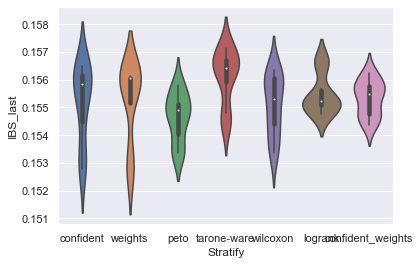

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


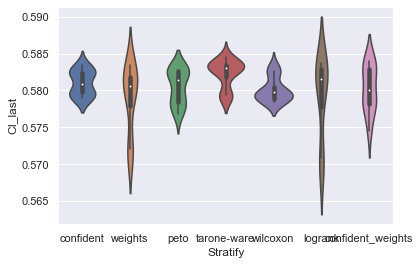

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


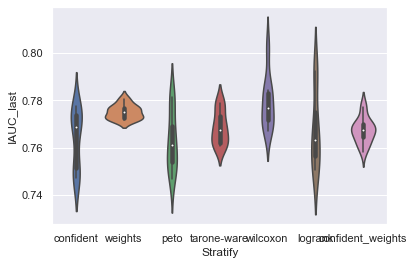

==================== ONK ====================


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


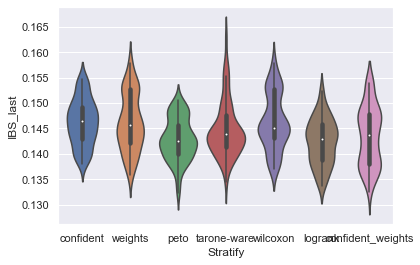

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


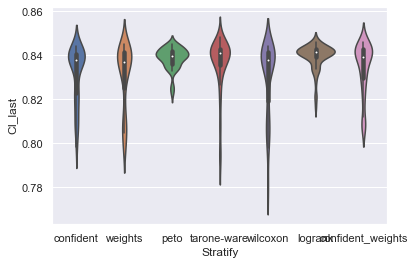

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


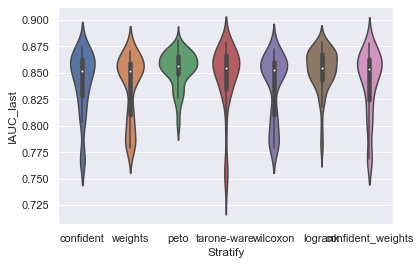

==================== GBSG ====================


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


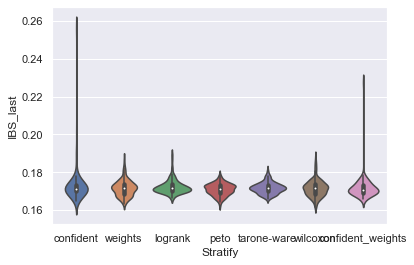

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


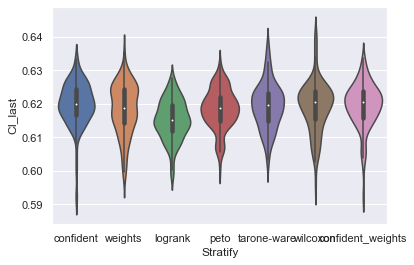

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


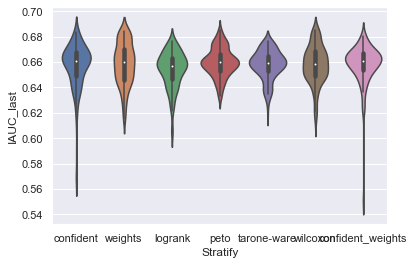

==================== PBC ====================


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


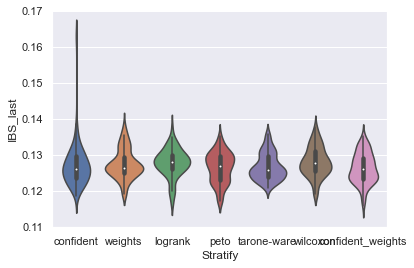

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


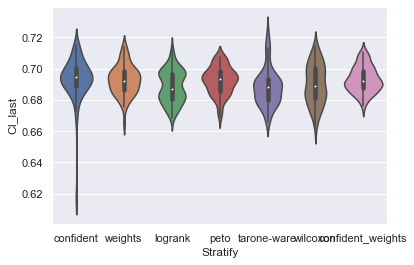

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


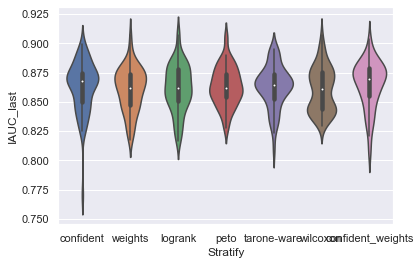

==================== WUHAN ====================


C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


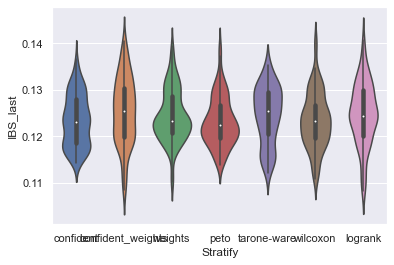

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


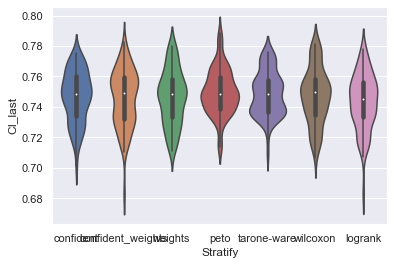

C:\ProgramData\Anaconda3\envs\survive\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


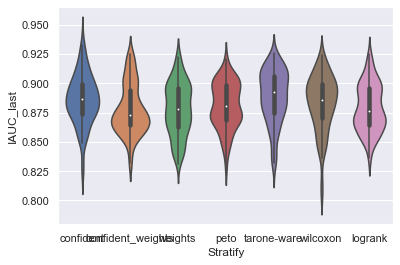

In [143]:
print_strat(datasets, "criterion")

==================== GBSG_FULL_TABLE.xls ====================


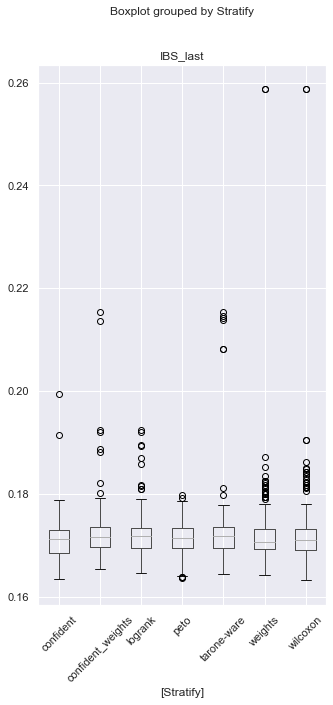

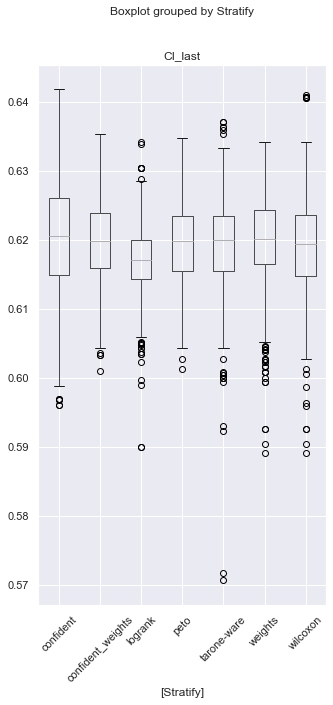

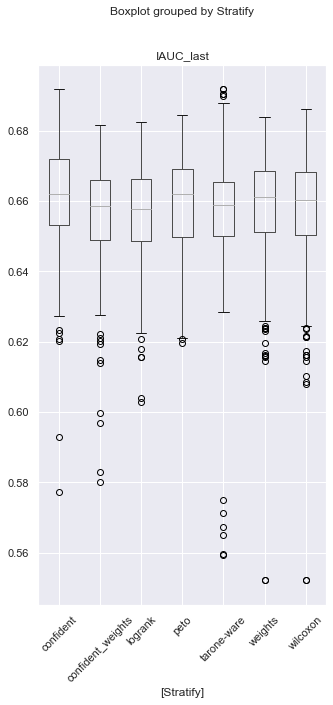

==================== PBC_FULL_TABLE.xls ====================


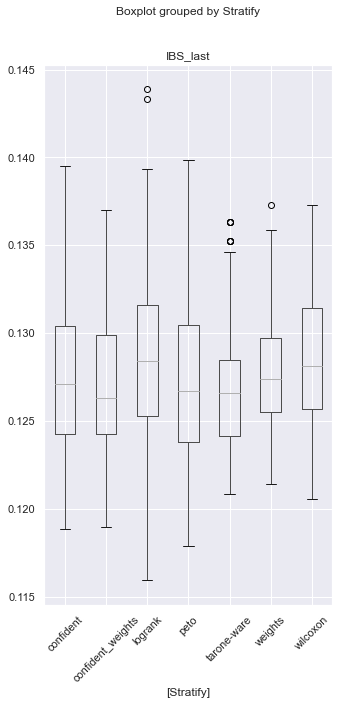

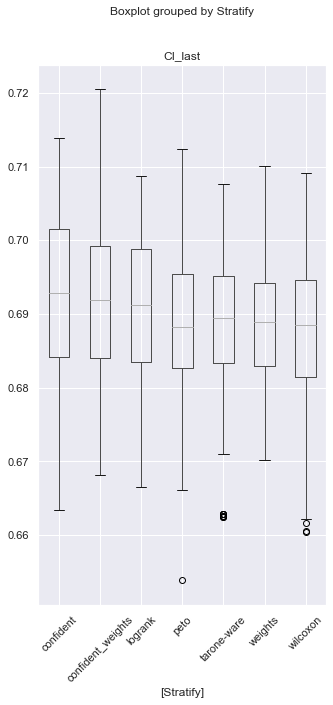

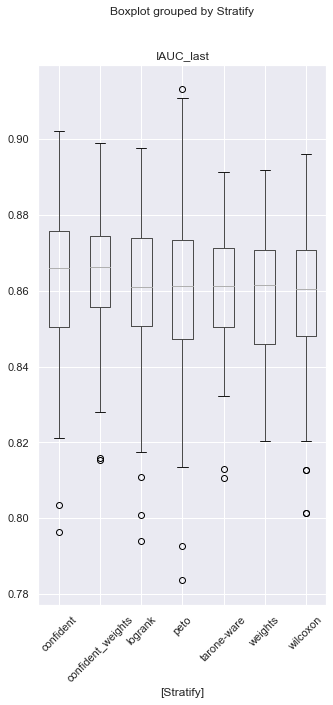

In [135]:
datasets_new = [
    "GBSG_FULL_TABLE.xlsx",
    "PBC_FULL_TABLE.xlsx"
]

print_strat(datasets_new, "criterion")